In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

# import jax.random
from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi
from einops import rearrange
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import random
# import math

## EDA

In [2]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True, cache_dir=r'C:\Aryan\4th Year\Winter\DSC 180B\DSC180B-Quarter-2-Project\data\raw\ONE', mode='local')
# ba = AllenAtlas()
pid = '73ff4936-8cd3-4a75-a772-f563e67d249d'
eid = 'ebe2efe3-e8a1-451a-8947-76ef42427cc9' # one.pid2eid(pid)[0]

In [20]:
eid

'ebe2efe3-e8a1-451a-8947-76ef42427cc9'

In [18]:
from pathlib import Path

In [34]:
Path.home() /'tables_dir' # C:\Aryan\4th Year\Winter\DSC 180B\DSC180B-Quarter-2-Project\data\raw

WindowsPath('C:/Users/asing/tables_dir')

In [3]:
# sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
# sl = SpikeSortingLoader(pid=pid, one=one)
sl = SpikeSortingLoader(one=one, eid=eid, pname='probe00')
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

In [17]:
sl.download_spike_sorting(path="C:\\Users\\asing\\Downloads\\")

KeyError: 'Unknown field "path"'

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-08-19_1_NYU-21_probe00, None \n4_804_128 spikes, 287 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

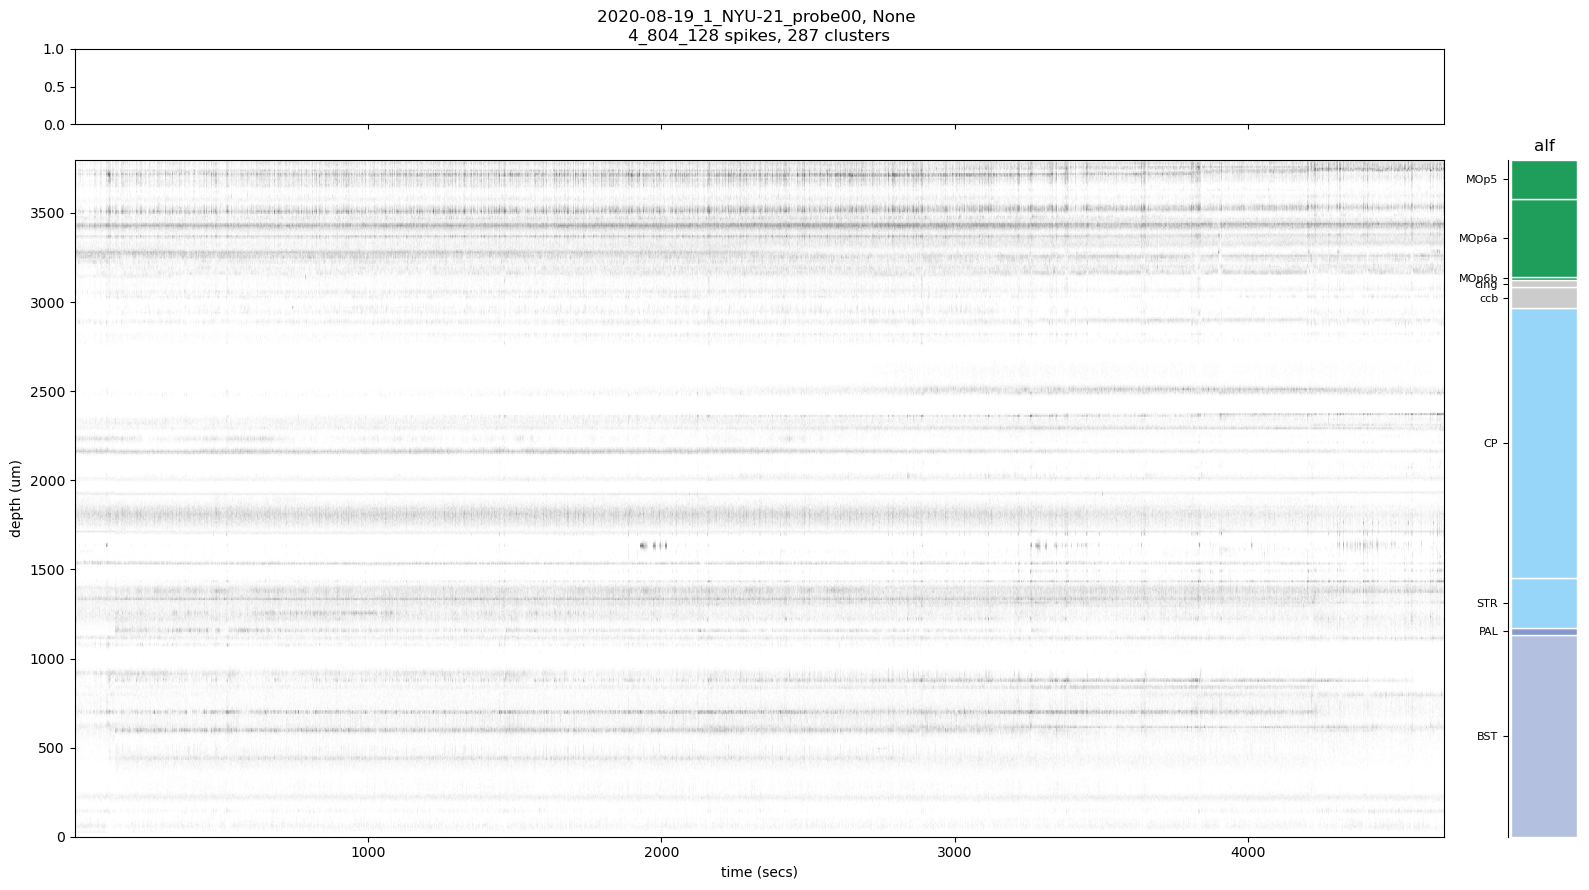

In [27]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons), and for brain regions MOp and MOs
2) Group spikes by neurons
3) Split data across trials
4) Bin spike times for each neuron, for each trial

In [4]:
# good_clusterIDs = clusters['cluster_id'][((clusters['label'] == 1) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
# good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters that are in MOp and MOs
good_clusterIDs = clusters['cluster_id'][((clusters['label'] > 0.5) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [5]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-08-19_1_NYU-21_probe00, None \n1_551_453 spikes, 58 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

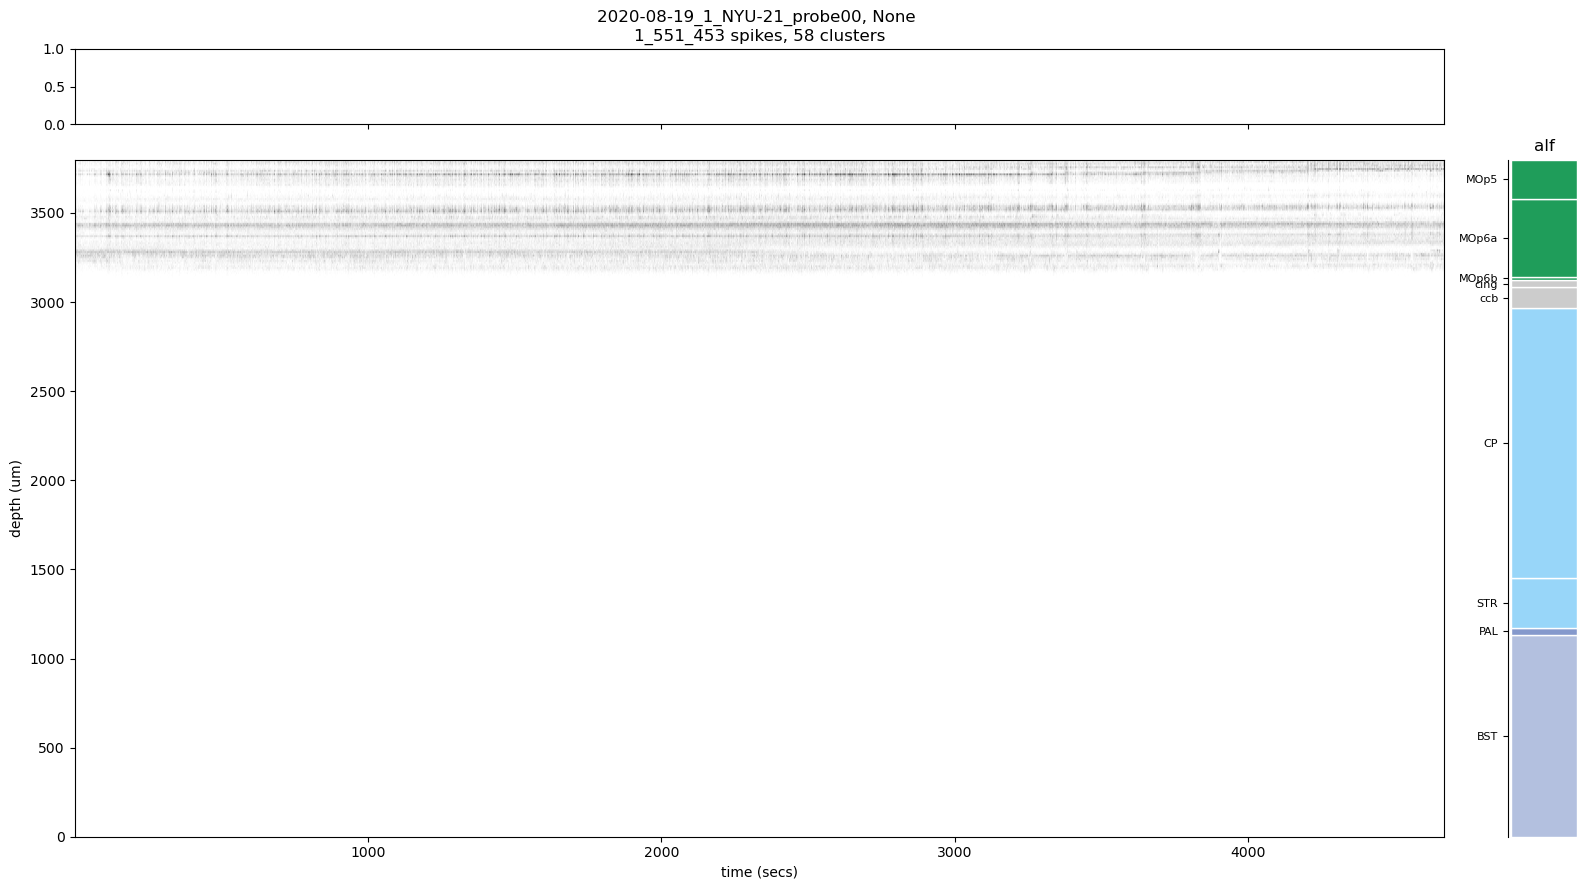

In [6]:
sl.raster(good_spikes, channels)

In [31]:
np.unique(trials['choice'])

array([-1.,  1.])

In [32]:
np.unique(trials['feedbackType'])

array([-1.,  1.])

In [7]:
bin_size = 50e-3 # in milliseconds
# min_bins = max(int((60e-3 / bin_size)), 20)
max_trial_type = 40 # Maximum number of trials of each trial type

In [8]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)

Implementation with bins as a fixed size:

In [12]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
#     try:
#         hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], bin_size)
#     except:
#         continue
#         # the hist bins throw an error if the go cute or first movement time is NaN
#         # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
#     if len(hist_bins) <= min_bins: # Mouse must have a minimum reaction time of 60 ms to be considered a good trial
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], hist_bins)[0])
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with a set number of bins instead of bin size:

In [13]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
    
#     time_range = (trials['firstMovement_times'][i] - trials['goCue_times'][i])
#     if ((time_range < 0.10) | (time_range > 0.300)): # Mouse must have a minimum reaction time of 60 ms to be considered a good trial. We also exlude trials longer than 300 ms because they will have too many spikes per bin
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], 200)[0]) # 200 bins
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with bins starting 100ms before first movement to 300 ms after first movement

In [9]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    if (trials['firstMovement_times'][i] < trials['goCue_times'][i]+0.05):
        continue
    
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['firstMovement_times'][i]-0.1, trials['firstMovement_times'][i]+1.00001, bin_size)
        # print(len(hist_bins))
    except:
        continue
        # the hist bins throw an error if the go cue or first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    
    for j in df: # Iterate through spike times of each cluster
        inds = ((j>(trials['firstMovement_times'][i]-0.1)) & (j<=(trials['firstMovement_times'][i]+1.00001))) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [10]:
random.shuffle(trials_spikes) # Randomize list before splitting into training and testing data

In [37]:
len(trials_spikes)

388

In [11]:
training_trials = []
testing_trials = []


trial_counts = {"correct_left" : [0, 0],  # [training count, testing count]
                "correct_right" : [0, 0],
                "incorrect_left" : [0, 0], # incorrect left means that the mouse chose left, and it was incorrect
                "incorrect_right": [0, 0]}

for i in trials_spikes:
    if ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if trial_counts['correct_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_left'][0] += 1
        elif trial_counts['correct_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==1)):
        if trial_counts['correct_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_right'][0] += 1
        elif trial_counts['correct_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_right'][1] += 1
        else:
            continue
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_left'][0] += 1
        elif trial_counts['incorrect_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_right'][0] += 1
        elif trial_counts['incorrect_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_right'][1] += 1
        else:
            continue

In [12]:
training_trials = trials_spikes[:250]
testing_trials = trials_spikes[250:]

In [40]:
len(training_trials)

250

In [13]:
training_trials[40]['spikes_df'].T

clusters,145,147,148,149,150,152,153,154,155,157,...,220,221,222,223,224,259,261,271,272,273
0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,2,0,0,1,0
3,0,0,3,0,0,0,0,0,1,1,...,0,1,1,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,0,1,0,...,0,2,0,0,0,0,0,0,0,0
5,1,1,0,0,1,1,0,0,3,1,...,0,1,1,0,0,1,1,0,0,0
6,0,0,1,0,2,0,0,0,2,0,...,0,2,0,0,0,1,2,0,0,0
7,1,0,0,0,1,1,0,1,1,0,...,0,1,0,0,0,1,3,1,0,0
8,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,3,0,0,0
9,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,3,0,0,0


In [14]:
session = Session(bin_size)
for i, trial in enumerate(training_trials):
    session.add_trial(i, y=trial['spikes_df'].T)

In [15]:
length_scale = 0.200 # in seconds
kernel = RBF(scale=1, lengthscale=length_scale)

In [16]:
session, params = vi.fit(session, n_factors=2, kernel=kernel, seed=10, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


EM Iteration 1, 	Loss = 28.0715, 	M step: 5.49s, 	E step: 18.93s
EM Iteration 2, 	Loss = 27.7338, 	M step: 1.89s, 	E step: 15.99s
EM Iteration 3, 	Loss = 27.6685, 	M step: 1.08s, 	E step: 16.11s
EM Iteration 4, 	Loss = 27.6328, 	M step: 1.09s, 	E step: 16.51s
EM Iteration 5, 	Loss = 27.6101, 	M step: 1.28s, 	E step: 16.83s
EM Iteration 6, 	Loss = 27.5950, 	M step: 1.10s, 	E step: 15.67s
EM Iteration 7, 	Loss = 27.5852, 	M step: 0.97s, 	E step: 16.42s
EM Iteration 8, 	Loss = 27.5792, 	M step: 1.22s, 	E step: 15.93s
EM Iteration 9, 	Loss = 27.5763, 	M step: 1.15s, 	E step: 15.95s
EM Iteration 10, 	Loss = 27.5756, 	M step: 1.15s, 	E step: 15.13s
EM Iteration 11, 	Loss = 27.5767, 	M step: 1.11s, 	E step: 16.72s
Inferring


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:408: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


Trial 0, 	Loss = 27.0841
Trial 1, 	Loss = 26.3519
Trial 2, 	Loss = 27.1561
Trial 3, 	Loss = 26.0182
Trial 4, 	Loss = 25.1370
Trial 5, 	Loss = 28.7813


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 6, 	Loss = 33.9322
Trial 7, 	Loss = 20.6356
Trial 8, 	Loss = 29.6363
Trial 9, 	Loss = 28.3732
Trial 10, 	Loss = 24.5931
Trial 11, 	Loss = 24.6312
Trial 12, 	Loss = 23.6476
Trial 13, 	Loss = 29.7869
Trial 14, 	Loss = 31.0430
Trial 15, 	Loss = 23.1539
Trial 16, 	Loss = 24.8392
Trial 17, 	Loss = 27.0941
Trial 18, 	Loss = 23.9610
Trial 19, 	Loss = 28.8341
Trial 20, 	Loss = 28.3690
Trial 21, 	Loss = 32.2201
Trial 22, 	Loss = 27.6812
Trial 23, 	Loss = 28.9073
Trial 24, 	Loss = 26.8011
Trial 25, 	Loss = 26.8502
Trial 26, 	Loss = 28.2970
Trial 27, 	Loss = 26.4866
Trial 28, 	Loss = 23.9133
Trial 29, 	Loss = 19.8956
Trial 30, 	Loss = 24.7990
Trial 31, 	Loss = 27.7458
Trial 32, 	Loss = 25.3247
Trial 33, 	Loss = 24.0459
Trial 34, 	Loss = 31.7745
Trial 35, 	Loss = 32.4053
Trial 36, 	Loss = 20.9721
Trial 37, 	Loss = 28.4899
Trial 38, 	Loss = 33.3970
Trial 39, 	Loss = 23.2532
Trial 40, 	Loss = 24.7711
Trial 41, 	Loss = 34.7626
Trial 42, 	Loss = 24.4377
Trial 43, 	Loss = 33.7672
Trial 44, 	Loss 

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:173: UserWarning: E: maximum number of iterations reached
  warnings.warn(f'E: maximum number of iterations reached')


Trial 95, 	Loss = 19.9956
Trial 96, 	Loss = 25.6023
Trial 97, 	Loss = 29.2128
Trial 98, 	Loss = 28.9762
Trial 99, 	Loss = 22.5842
Trial 100, 	Loss = 27.2549
Trial 101, 	Loss = 32.1261
Trial 102, 	Loss = 24.7259
Trial 103, 	Loss = 25.3492
Trial 104, 	Loss = 28.1436
Trial 105, 	Loss = 28.2605
Trial 106, 	Loss = 32.4367
Trial 107, 	Loss = 32.2169
Trial 108, 	Loss = 32.7406
Trial 109, 	Loss = 23.0306
Trial 110, 	Loss = 23.1248
Trial 111, 	Loss = 32.6670
Trial 112, 	Loss = 28.9324
Trial 113, 	Loss = 30.3087
Trial 114, 	Loss = 28.0804
Trial 115, 	Loss = 29.2326
Trial 116, 	Loss = 27.1849
Trial 117, 	Loss = 30.4782
Trial 118, 	Loss = 33.0086
Trial 119, 	Loss = 25.7532
Trial 120, 	Loss = 27.4320
Trial 121, 	Loss = 24.2793
Trial 122, 	Loss = 27.8094
Trial 123, 	Loss = 31.9585
Trial 124, 	Loss = 34.3749
Trial 125, 	Loss = 23.3219
Trial 126, 	Loss = 28.5299
Trial 127, 	Loss = 27.6093
Trial 128, 	Loss = 26.9485
Trial 129, 	Loss = 27.4772
Trial 130, 	Loss = 24.7111
Trial 131, 	Loss = 29.2363
Trial 

In [17]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

In [18]:
# Find testing trajectories
sessionTest = Session(bin_size)
for i, trial in enumerate(testing_trials):
    sessionTest.add_trial(i, y=trial['spikes_df'].T)

sessionTest = vi.infer(sessionTest, params=params, )
z_test = rearrange(sessionTest.z, '(trials time) lat -> trials time lat', time=testing_trials[0]['spikes_df'].shape[1])

Trial 0, 	Loss = 22.0742
Trial 1, 	Loss = 24.3888
Trial 2, 	Loss = 20.7377
Trial 3, 	Loss = 25.9947
Trial 4, 	Loss = 32.9310
Trial 5, 	Loss = 25.0281
Trial 6, 	Loss = 21.5726


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 7, 	Loss = 23.7021
Trial 8, 	Loss = 32.0795
Trial 9, 	Loss = 32.4150
Trial 10, 	Loss = 25.6291
Trial 11, 	Loss = 21.8356
Trial 12, 	Loss = 26.2527
Trial 13, 	Loss = 28.6435
Trial 14, 	Loss = 28.5015
Trial 15, 	Loss = 25.3734
Trial 16, 	Loss = 23.7497
Trial 17, 	Loss = 24.1591
Trial 18, 	Loss = 25.4829
Trial 19, 	Loss = 31.3314
Trial 20, 	Loss = 25.3936
Trial 21, 	Loss = 23.4266
Trial 22, 	Loss = 25.9838
Trial 23, 	Loss = 27.6838
Trial 24, 	Loss = 24.9104
Trial 25, 	Loss = 24.9863
Trial 26, 	Loss = 24.0619
Trial 27, 	Loss = 19.5257
Trial 28, 	Loss = 24.5616
Trial 29, 	Loss = 31.8170
Trial 30, 	Loss = 23.6842
Trial 31, 	Loss = 32.6470
Trial 32, 	Loss = 27.2397
Trial 33, 	Loss = 26.2033
Trial 34, 	Loss = 29.4654
Trial 35, 	Loss = 27.7084
Trial 36, 	Loss = 27.7856
Trial 37, 	Loss = 25.7563
Trial 38, 	Loss = 29.3106
Trial 39, 	Loss = 34.6784
Trial 40, 	Loss = 27.5578
Trial 41, 	Loss = 23.1072
Trial 42, 	Loss = 37.6731
Trial 43, 	Loss = 29.3414
Trial 44, 	Loss = 25.5803
Trial 45, 	Loss

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:173: UserWarning: E: maximum number of iterations reached
  warnings.warn(f'E: maximum number of iterations reached')


Trial 53, 	Loss = 24.5879
Trial 54, 	Loss = 21.9029
Trial 55, 	Loss = 29.3316
Trial 56, 	Loss = 31.4543
Trial 57, 	Loss = 32.2975
Trial 58, 	Loss = 27.8281
Trial 59, 	Loss = 27.3636
Trial 60, 	Loss = 21.7725
Trial 61, 	Loss = 33.8951
Trial 62, 	Loss = 34.0931
Trial 63, 	Loss = 22.9896
Trial 64, 	Loss = 19.9712
Trial 65, 	Loss = 22.2823
Trial 66, 	Loss = 28.5713
Trial 67, 	Loss = 26.9960
Trial 68, 	Loss = 25.4199
Trial 69, 	Loss = 22.1089
Trial 70, 	Loss = 23.8548
Trial 71, 	Loss = 34.3897
Trial 72, 	Loss = 22.2518
Trial 73, 	Loss = 24.4378
Trial 74, 	Loss = 21.1694
Trial 75, 	Loss = 24.5162
Trial 76, 	Loss = 30.4602
Trial 77, 	Loss = 29.7078
Trial 78, 	Loss = 27.6639
Trial 79, 	Loss = 20.2516
Trial 80, 	Loss = 28.3339
Trial 81, 	Loss = 32.9147
Trial 82, 	Loss = 33.7889
Trial 83, 	Loss = 29.0307
Trial 84, 	Loss = 25.5065
Trial 85, 	Loss = 28.0442
Trial 86, 	Loss = 25.3426
Trial 87, 	Loss = 20.8974
Trial 88, 	Loss = 27.4326
Trial 89, 	Loss = 24.7403
Trial 90, 	Loss = 25.2892
Trial 91, 	L

### Plot training trajectories and add them to test set. Plot test trajectories after


In [30]:
len(np.arange(-0.1, 1, 0.05))

22

In [39]:
import plotly.graph_objects as go

In [65]:
z_train = rearrange(session.z, '(trials time) lat -> trials time lat', time=training_trials[0]['spikes_df'].shape[1])

first = True
first2= True
time_sig = 4
X_class_train = []
y_class_train = []
time_bins = len(z_train[i][:, 0])

fig = go.Figure()
for i in range(len(z_train)):
    if ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig.add_trace(go.Scatter3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                      mode='lines', line={'color':'blue', 'width':1}, legendgroup='right', name='Wheel Turned Right', showlegend=True))
            first = False
        else:
            fig.add_trace(go.Scatter3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                        mode='lines', line={'color':'blue', 'width':1}, legendgroup='right', showlegend=False))
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(0)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==1)):
        if first2:
            fig.add_trace(go.Scatter3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                      mode='lines', line={'color':'red', 'width':1}, legendgroup='left', name='Wheel Turned Left', showlegend=True))
            first2 = False
        else:
            fig.add_trace(go.Scatter3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                        mode='lines', line={'color':'red', 'width':1}, legendgroup='left', showlegend=False))
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(1)
        
    elif ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(2)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=1)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(3)
        

X_class_test = []
y_class_test = []

# Plot testing trajectories
for i in range(len(z_test)):
    if ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(0)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(1)
        
    elif ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(2)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(3)

X_class_train = np.array(X_class_train)
y_class_train = np.array(y_class_train)
X_class_test = np.array(X_class_test)
y_class_test = np.array(y_class_test)

fig.update_layout(scene = dict(
                    xaxis_title='Time (ms)',
                    yaxis_title='Latent Variable 1',
                    zaxis_title='Latent Variable 2'),
                    width=800, height=800, title='Latent Variables over Time'
                    )
fig.show()

In [38]:
z_train = rearrange(session.z, '(trials time) lat -> trials time lat', time=training_trials[0]['spikes_df'].shape[1])

first = True
time_sig = 4
X_class_train = []
y_class_train = []
time_bins = len(z_train[i][:, 0])

for i in range(len(z_train)):
    if ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig = px.line_3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                             color=["blue"]*time_bins, width=800, height=800, title="Latent Variables over Time",
                             labels={'x':'Time (ms)', 'y':'Latent Variable 1', 'z':'Latent Variable 2'}, line_group='group1')
            first = False
        else:
            fig.add_scatter3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1], mode='lines', line={'color':"blue"}, opacity=0.5, line_group='group1')
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(0)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==1)):
        if first:
            fig = px.line_3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1],
                             color=["red"]*time_bins, width=800, height=800, title="Latent Variables over Time",
                             labels={'x':'Time (ms)', 'y':'Latent Variable 1', 'z':'Latent Variable 2'},line_group='group2')
            first = False
        else:
            fig.add_scatter3d(x=np.arange(-100, 1000, 50), y=z_train[i][:, 0], z=z_train[i][:, 1], mode='lines', line={'color':"red"}, opacity=0.5, line_group='group2')
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(1)
        
    elif ((training_trials[i]['choice']==1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(2)
        
    elif ((training_trials[i]['choice']==-1) & (training_trials[i]['feedbackType']==-1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(-0.1, 1, 0.05), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=1)
        X_class_train.append(z_train[i][time_sig]); y_class_train.append(3)
        

X_class_test = []
y_class_test = []

# Plot testing trajectories
for i in range(len(z_test)):
    if ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["green"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"green"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'green', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(0)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==1)):
        # if first:
        #     fig = px.line_3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], color=["black"]*time_bins, width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=np.arange(time_bins), y=z_test[i][:, 0], z=z_test[i][:, 1], mode='lines', line={'color':"black"}, opacity=0.5)
        # fig.add_scatter3d(x=[time_sig], y=z_train[i][time_sig:time_sig+1, 0], z=z_train[i][time_sig:time_sig+1, 1], mode='markers', marker={'color':'black', 'size':5})  # show point of significance
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(1)
        
    elif ((testing_trials[i]['choice']==1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(2)
        
    elif ((testing_trials[i]['choice']==-1) & (testing_trials[i]['feedbackType']==-1)):
        X_class_test.append(z_test[i][time_sig]); y_class_test.append(3)

X_class_train = np.array(X_class_train)
y_class_train = np.array(y_class_train)
X_class_test = np.array(X_class_test)
y_class_test = np.array(y_class_test)

fig.show()

TypeError: line_3d() got an unexpected keyword argument 'legendgroup'

In [20]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(X_class_train, y_class_train)
print(mod.score(X_class_train, y_class_train))
mod.score(X_class_test, y_class_test)

0.776


0.7246376811594203

0.9368932038834952
0.970873786407767


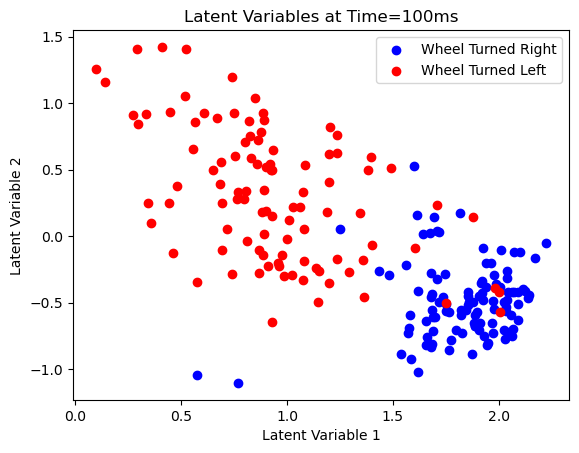

In [81]:
# Predict between Just correct left and correct right
X_class_train01 = X_class_train[((y_class_train==0) | (y_class_train==1))]
y_class_train01 = y_class_train[((y_class_train==0) | (y_class_train==1))]
X_class_test01 = X_class_test[((y_class_test==0) | (y_class_test==1))]
y_class_test01 = y_class_test[((y_class_test==0) | (y_class_test==1))]


mod = LogisticRegression()
mod.fit(X_class_train01, y_class_train01)
print(mod.score(X_class_train01, y_class_train01))
print(mod.score(X_class_test01, y_class_test01))

plt.scatter(X_class_train[y_class_train==0][:, 0], X_class_train[y_class_train==0][:, 1], color='blue', label='Wheel Turned Right')
plt.scatter(X_class_train[y_class_train==1][:, 0], X_class_train[y_class_train==1][:, 1], color='red', label='Wheel Turned Left')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables at Time=100ms')
plt.legend()

0.8907563025210085
0.8135593220338984


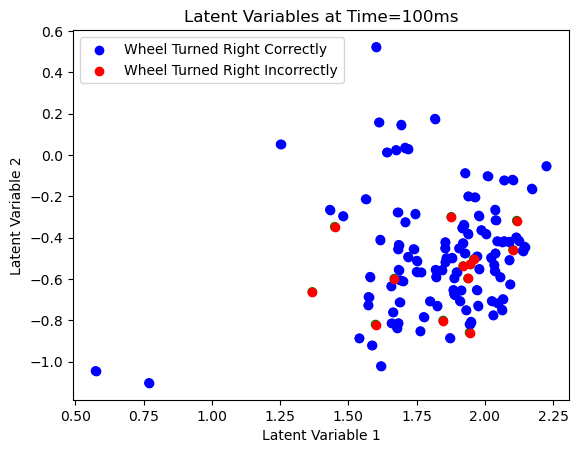

In [83]:
# Predict between Just correct left and incorrect left. Obtains a low accuracy compared to baseline
X_class_train02 = X_class_train[((y_class_train==0) | (y_class_train==2))]
y_class_train02 = y_class_train[((y_class_train==0) | (y_class_train==2))]
X_class_test02 = X_class_test[((y_class_test==0) | (y_class_test==2))]
y_class_test02 = y_class_test[((y_class_test==0) | (y_class_test==2))]


mod = LogisticRegression()
mod.fit(X_class_train02, y_class_train02)
print(mod.score(X_class_train02, y_class_train02))
print(mod.score(X_class_test02, y_class_test02)) # is 1 because the test set is unbalanced

plt.scatter(X_class_train02[:, 0], X_class_train02[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train02])
plt.scatter(X_class_train[y_class_train==0][:, 0], X_class_train[y_class_train==0][:, 1], color='blue', label='Wheel Turned Right Correctly')
plt.scatter(X_class_train[y_class_train==2][:, 0], X_class_train[y_class_train==2][:, 1], color='red', label='Wheel Turned Right Incorrectly')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables at Time=100ms')
plt.legend()

0.8978102189781022
0.8333333333333334


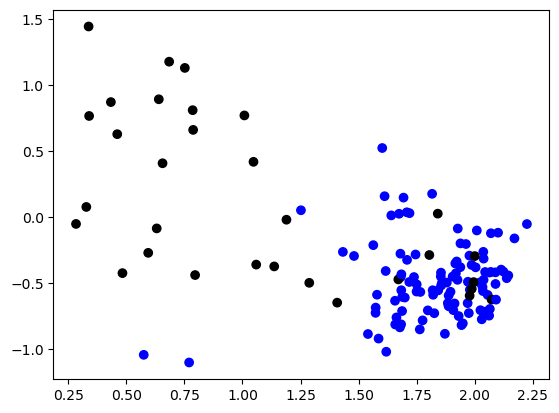

In [23]:
# Predict between correct left and incorrect right
X_class_train03 = X_class_train[((y_class_train==0) | (y_class_train==3))]
y_class_train03 = y_class_train[((y_class_train==0) | (y_class_train==3))]
X_class_test03 = X_class_test[((y_class_test==0) | (y_class_test==3))]
y_class_test03 = y_class_test[((y_class_test==0) | (y_class_test==3))]


mod = LogisticRegression()
mod.fit(X_class_train03, y_class_train03)
print(mod.score(X_class_train03, y_class_train03))
print(mod.score(X_class_test03, y_class_test03))

plt.scatter(X_class_train03[:, 0], X_class_train03[:, 1], color=np.array(['blue', 'red', 'green', 'black'])[y_class_train03])